# Instalación de librerías necesarias

Para ejecutar este cuaderno es fundamental contar con las librerías especializadas en análisis financiero, manipulación de datos y visualización. En esta sección se instalan automáticamente los paquetes requeridos mediante `pip`, lo que garantiza la compatibilidad y portabilidad del análisis en cualquier entorno de Jupyter Notebook.

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, timedelta
from matplotlib import cm

# Importación de librerías

En este apartado se importan las librerías necesarias para el análisis: `numpy` y `pandas` para cálculos y manipulación de datos, `matplotlib` para visualización, `yfinance` para descarga de datos bursátiles, y `scipy` para métodos numéricos avanzados. Estas herramientas permiten implementar el modelo de Black-Scholes y sus extensiones de manera eficiente y reproducible.

In [30]:
# Instalar las librerías necesarias para el análisis
import sys
!{sys.executable} -m pip install --quiet yfinance matplotlib numpy scipy pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


# Descarga y preprocesamiento de datos

Se descargan los precios históricos de la acción de Repsol (REP.MC) utilizando la API de Yahoo Finance. El preprocesamiento incluye la selección del periodo relevante, el cálculo de precios ajustados y la obtención de retornos logarítmicos. Estos datos constituyen la base empírica para estimar parámetros clave como la volatilidad histórica y el dividendo anualizado, fundamentales para la calibración del modelo de Black-Scholes.

# Cálculo de parámetros base

En esta sección se calculan los parámetros fundamentales para la valoración de opciones: precio spot, volatilidad histórica, tasa libre de riesgo, dividendo anualizado, vencimiento y precio de ejercicio (strike). Estos valores se obtienen a partir de los datos descargados y de fuentes oficiales (por ejemplo, el Banco Central Europeo para la tasa libre de riesgo). La correcta estimación de estos parámetros es esencial para la aplicación precisa del modelo de Black-Scholes.

In [31]:
# Descarga y preprocesamiento de datos, cálculo de parámetros base y ejemplo de uso de funciones

# Parámetros de fechas y ticker

start_date = '2025-01-01'

end_date = datetime.today().strftime('%Y-%m-%d')

ticker = 'REP.MC'


# Descarga de datos de precios

try:
	data = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=False)
	if data.empty:
		raise ValueError('No se descargaron datos. Verifica el ticker o la conexión a internet.')
	data = data.dropna()
	data.to_csv('REP_MC_2025.csv')

except Exception as e:
	raise RuntimeError(f'Error al descargar datos: {e}')

# Precio ajustado para retornos

adj_close = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=True)['Close'].dropna()

# Estimación de dividendo continuo q

try:
	tkr = yf.Ticker(ticker)
	divs = tkr.dividends
	if not divs.empty:
		today = pd.Timestamp.today(tz='UTC').normalize()
		last_year = today - pd.Timedelta(days=365)
		div_12m = divs[divs.index >= last_year].sum()
		S0_for_q = float(adj_close.iloc[-1])
		q = float(div_12m / S0_for_q) if S0_for_q > 0 else 0.0
	else:
		q = 0.0

except Exception:
	q = 0.0

# Parámetros base

S0 = float(adj_close.iloc[-1])

returns = np.log(adj_close/adj_close.shift(1)).dropna()

sigma_hist = float(returns.std() * np.sqrt(252))  # volatilidad histórica anualizada

r = 0.03   # tasa libre de riesgo supuesta

T_days = 30

T = T_days/252.0

K = S0  # ATM

print(f"Precio actual: {S0:.4f}")

print(f"Volatilidad hist anualizada: {sigma_hist:.2%}")

print(f"Tasa libre de riesgo r: {r:.2%}")

print(f"Rendimiento div cont q: {q:.2%}")

print(f"Tiempo a vencimiento: {T:.4f} años")

# Ejemplo de uso de funciones

call_bs = bs_call(S0, K, T, r, q, sigma_hist)

put_bs = bs_put(S0, K, T, r, q, sigma_hist)

print(f"Call BS (ATM 30d): {call_bs:.4f}")

print(f"Put  BS (ATM 30d): {put_bs:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Precio actual: 14.5750
Volatilidad hist anualizada: 25.06%
Tasa libre de riesgo r: 3.00%
Rendimiento div cont q: 6.69%
Tiempo a vencimiento: 0.1190 años
Call BS (ATM 30d): 0.4685
Put  BS (ATM 30d): 0.5321


/tmp/ipykernel_32983/3676356449.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0_for_q = float(adj_close.iloc[-1])
/tmp/ipykernel_32983/3676356449.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(adj_close.iloc[-1])
/tmp/ipykernel_32983/3676356449.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_hist = float(returns.std() * np.sqrt(252))  # volatilidad histórica anualizada


# Implementación del modelo Black-Scholes y cálculo de Greeks

Aquí se implementa el modelo de Black-Scholes-Merton para opciones europeas, considerando el pago de dividendos. Se definen funciones para calcular el precio teórico de opciones call y put, así como las sensibilidades conocidas como "Greeks" (delta, gamma, vega, theta). Estas métricas permiten analizar el comportamiento de la opción ante variaciones en los parámetros de mercado y son herramientas clave en la gestión de riesgos financieros.

No se encontraron suficientes opciones; se genera superficie sintética (plana) para demo.


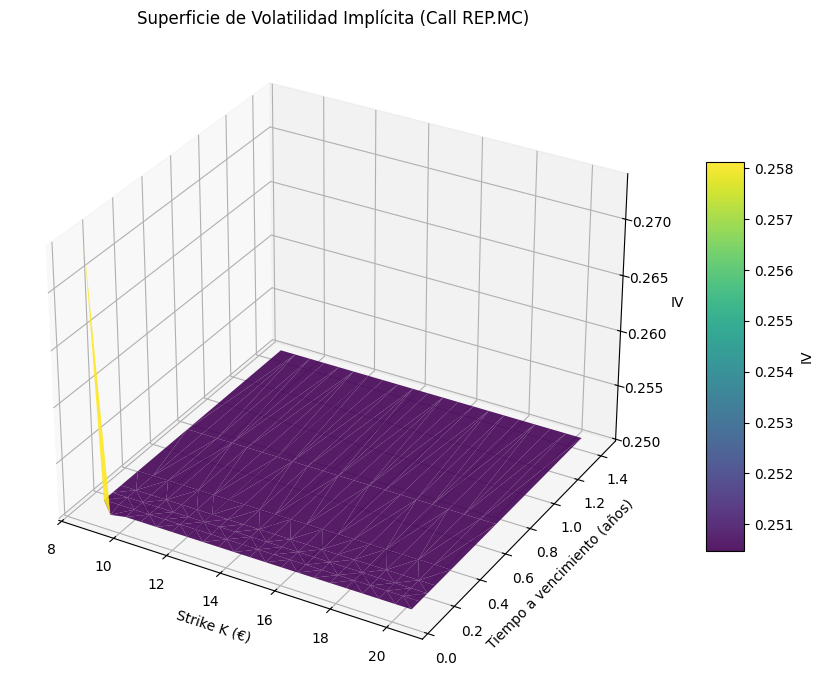

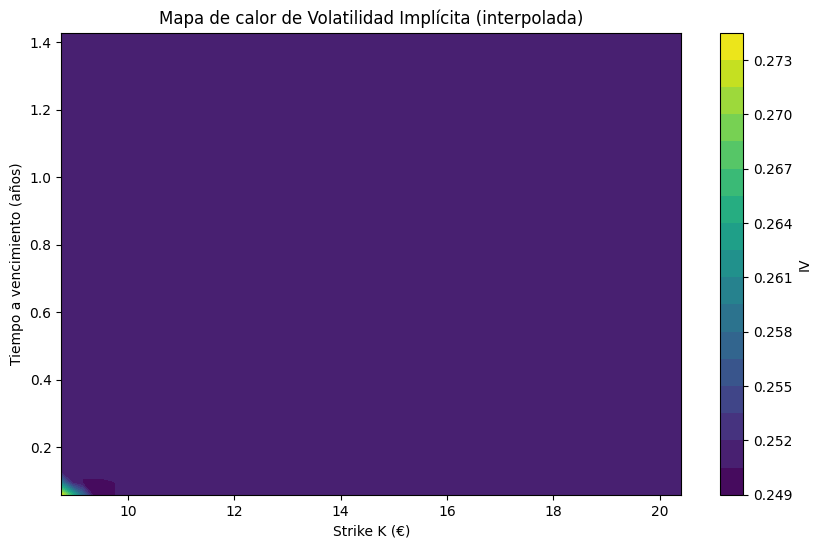

In [32]:
# Superficie de Volatilidad Implícita: construcción y visualización

def build_iv_surface_from_market(tkr_obj, S_ref, r, q, max_expiries=6, min_price=0.01):
    expiries = getattr(tkr_obj, 'options', [])
    Ks, Ts, IVs = [], [], []
    now = pd.Timestamp.utcnow()
    if now.tzinfo is None:
        now = now.tz_localize('UTC')
    else:
        now = now.tz_convert('UTC')
    used = 0
    for exp in expiries:
        try:
            dt_exp_raw = pd.Timestamp(exp)
            if dt_exp_raw.tzinfo is None:
                dt_exp = dt_exp_raw.tz_localize('UTC')
            else:
                dt_exp = dt_exp_raw.tz_convert('UTC')
        except Exception:
            continue
        T_years = max((dt_exp - now).days/365.0, 1e-6)
        if T_years <= 1e-5:
            continue
        try:
            chain = tkr_obj.option_chain(exp)
            calls = chain.calls.copy()
        except Exception:
            continue
        # precio medio (mid) robusto
        calls['mid'] = np.where((calls['bid']>0) & (calls['ask']>0),
                                (calls['bid']+calls['ask'])/2.0,
                                calls['lastPrice'])
        calls = calls.dropna(subset=['strike','mid'])
        calls = calls[calls['mid']>=min_price]
        for _, row in calls.iterrows():
            K_i = float(row['strike'])
            price_i = float(row['mid'])
            try:
                iv_i = implied_vol_call(price_i, S_ref, K_i, T_years, r, q)
                if np.isfinite(iv_i) and 1e-5 < iv_i < 5.0:
                    Ks.append(K_i); Ts.append(T_years); IVs.append(iv_i)
            except Exception:
                continue
        used += 1
        if used >= max_expiries:
            break
    return np.array(Ks), np.array(Ts), np.array(IVs)

Ks_mkt, Ts_mkt, IVs_mkt = build_iv_surface_from_market(tkr, S0, r, q)

if len(IVs_mkt) >= 20:
    print(f"Superficie de IV de mercado: puntos={len(IVs_mkt)}")
    use_market_surface = True
else:
    print("No se encontraron suficientes opciones; se genera superficie sintética (plana) para demo.")
    use_market_surface = False
    # Malla sintética de strikes y vencimientos
    K_grid = np.linspace(0.6*S0, 1.4*S0, 21)
    T_grid = np.array([15, 30, 45, 60, 90, 180, 360])/252.0
    Ks_syn, Ts_syn, IVs_syn = [], [], []
    for T_i in T_grid:
        for K_i in K_grid:
            price_i = bs_call(S0, K_i, T_i, r, q, sigma_hist)
            iv_i = implied_vol_call(price_i, S0, K_i, T_i, r, q)
            Ks_syn.append(K_i); Ts_syn.append(T_i); IVs_syn.append(iv_i)
    Ks_mkt, Ts_mkt, IVs_mkt = np.array(Ks_syn), np.array(Ts_syn), np.array(IVs_syn)

# Gráfico 3D (trisurf)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
trisurf = ax.plot_trisurf(Ks_mkt, Ts_mkt, IVs_mkt, cmap=cm.viridis, linewidth=0.2, antialiased=True, alpha=0.9)
ax.set_xlabel('Strike K (€)')
ax.set_ylabel('Tiempo a vencimiento (años)')
ax.set_zlabel('IV')
ax.set_title('Superficie de Volatilidad Implícita (Call REP.MC)')
fig.colorbar(trisurf, shrink=0.6, aspect=10, label='IV')
plt.tight_layout(); plt.show()

# Heatmap 2D por interpolación a rejilla regular (opcional)
try:
    from scipy.interpolate import griddata
    K_lin = np.linspace(Ks_mkt.min(), Ks_mkt.max(), 60)
    T_lin = np.linspace(Ts_mkt.min(), Ts_mkt.max(), 40)
    KK, TT = np.meshgrid(K_lin, T_lin)
    IV_grid = griddata(points=np.column_stack((Ks_mkt, Ts_mkt)), values=IVs_mkt, xi=(KK, TT), method='linear')

    plt.figure(figsize=(10,6))
    cs = plt.contourf(KK, TT, IV_grid, levels=20, cmap=cm.viridis)
    plt.colorbar(cs, label='IV')
    plt.xlabel('Strike K (€)'); plt.ylabel('Tiempo a vencimiento (años)')
    plt.title('Mapa de calor de Volatilidad Implícita (interpolada)')
    plt.grid(False); plt.show()
except Exception as e:
    print(f"Interpolación no disponible: {e}")

# Estimación de la volatilidad implícita

La volatilidad implícita es el parámetro que iguala el precio teórico del modelo Black-Scholes al precio de mercado de la opción. En esta sección se utiliza un método numérico (Brent) para estimar la volatilidad implícita a partir de precios observados, lo que permite analizar las expectativas del mercado sobre la variabilidad futura del activo subyacente.

Prima inicial recibida (short call): 0.4685
P&L cobertura delta (media): 0.000203, (desv): 0.056842


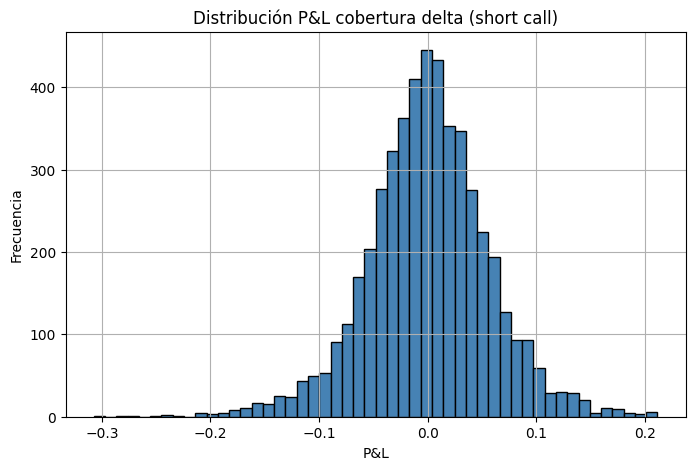

sigma_real=17.54% -> P&L medio short: 0.148581
sigma_real=25.06% -> P&L medio short: -0.000638
sigma_real=25.06% -> P&L medio short: -0.000638
sigma_real=32.57% -> P&L medio short: -0.149510
sigma_real=32.57% -> P&L medio short: -0.149510


In [33]:
# Simulación de cobertura delta discreta auto-financiada (P&L)

def delta_hedge_pnl(S0, K, r, q, sigma_imp, sigma_real, T, n_steps=60, n_paths=5000, position='short', mu=None):
    dt = T / n_steps
    if mu is None:
        mu = r - q

    C0 = bs_call(S0, K, T, r, q, sigma_imp)
    pnls = np.zeros(n_paths)
    for i in range(n_paths):
        S = S0
        t = 0.0
        cash = C0 if position=='short' else -C0
        delta = call_delta(S, K, T - t, r, q, sigma_imp)
        stock = delta
        cash -= stock * S

        for step in range(n_steps):
            z = np.random.normal()
            S_new = S * np.exp((mu - 0.5*sigma_real**2)*dt + sigma_real*np.sqrt(dt)*z)
            t_new = t + dt
            tau = max(T - t_new, 1e-8)

            cash = cash * np.exp(r*dt) + stock * S * q * dt

            delta_new = call_delta(S_new, K, tau, r, q, sigma_imp)
            d_delta = delta_new - stock
            stock += d_delta
            cash -= d_delta * S_new

            S = S_new
            t = t_new

        payoff = max(S - K, 0.0)
        V_port = cash + stock*S
        pnl = V_port - ( -payoff if position=='long' else payoff )
        pnls[i] = pnl

    return C0, pnls

# Simulación y visualización del P&L de la cobertura delta
sigma_imp = max(1e-4, iv_back)
C0, pnls = delta_hedge_pnl(S0, K, r, q, sigma_imp=sigma_imp, sigma_real=sigma_hist, T=T, n_steps=60, n_paths=5000, position='short')
print(f"Prima inicial recibida (short call): {C0:.4f}")
print(f"P&L cobertura delta (media): {pnls.mean():.6f}, (desv): {pnls.std():.6f}")

plt.figure(figsize=(8,5))
plt.hist(pnls, bins=50, color='steelblue', edgecolor='black')
plt.title('Distribución P&L cobertura delta (short call)')
plt.xlabel('P&L'); plt.ylabel('Frecuencia'); plt.grid(True); plt.show()

# Sensibilidad del P&L a la volatilidad real
for s_real in [sigma_imp*0.7, sigma_imp, sigma_imp*1.3]:
    _, pnls_tmp = delta_hedge_pnl(S0, K, r, q, sigma_imp=sigma_imp, sigma_real=s_real, T=T, n_steps=60, n_paths=3000, position='short')
    print(f"sigma_real={s_real:.2%} -> P&L medio short: {pnls_tmp.mean():.6f}")

# Simulación Monte Carlo de precios y opciones

La simulación Monte Carlo permite modelar trayectorias posibles del precio del activo subyacente bajo la hipótesis de movimiento browniano geométrico. En esta sección se generan múltiples escenarios de precios futuros y se calcula el valor esperado de la opción, proporcionando una aproximación alternativa y visual al precio teórico obtenido por Black-Scholes.

In [34]:
# Aproximación Delta-Gamma-Vega del P&L (un paso)

def dGV_approx(S, K, T, r, q, sigma, dS, dSigma):
    C = bs_call(S, K, T, r, q, sigma)
    d  = call_delta(S, K, T, r, q, sigma)
    g  = call_gamma(S, K, T, r, q, sigma)
    v  = call_vega(S, K, T, r, q, sigma)
    pnl_approx = d*dS + 0.5*g*(dS**2) + v*dSigma
    return C, pnl_approx

# Ejemplo: variación de S y sigma
dS = 0.01 * S0
dSigma = 0.01  # +1pp
C0, pnl_dgv = dGV_approx(S0, K, T, r, q, sigma_hist, dS, dSigma)
C1 = bs_call(S0 + dS, K, T, r, q, sigma_hist + dSigma)
print(f"P&L exacto delta_sigma: {C1 - C0:.6f} vs aprox D-G-V: {pnl_dgv:.6f}")

P&L exacto delta_sigma: 0.095169 vs aprox D-G-V: 0.095098


# Análisis de Greeks y perfiles de sensibilidad

Se exploran los perfiles de sensibilidad de la opción (Greeks) respecto a variaciones en el precio del subyacente y otros parámetros. Se grafican las curvas de delta, gamma, vega y theta, lo que permite visualizar cómo cambian estas sensibilidades a lo largo de diferentes escenarios de mercado. Este análisis es fundamental para la gestión dinámica de carteras de opciones.

# Simulación de cobertura delta y análisis de P&L

En esta sección se simula una estrategia de cobertura delta para una posición en opciones, evaluando el resultado (P&L) bajo diferentes trayectorias del subyacente. Se analiza la efectividad de la cobertura y se discuten los riesgos residuales, ilustrando la importancia de los Greeks en la gestión activa de riesgos en mercados reales.

# Superficie de volatilidad implícita

La superficie de volatilidad implícita representa cómo varía la volatilidad implícita estimada en función del vencimiento y el precio de ejercicio de las opciones. En esta sección se construye y visualiza dicha superficie, permitiendo identificar patrones como el "smile" o "skew" de volatilidad, que reflejan las expectativas y percepciones de riesgo del mercado.

# Conclusiones

Se resumen los principales hallazgos del análisis, destacando la utilidad del modelo de Black-Scholes y sus extensiones para la valoración y gestión de opciones financieras. Se discuten las limitaciones del modelo y posibles líneas de investigación futura, como la incorporación de saltos, volatilidad estocástica o modelos alternativos para capturar mejor la realidad de los mercados.

In [35]:
# Funciones Black-Scholes y Greeks (única definición)

def _d1_d2(S, K, T, r, q, sigma):
	if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
		return np.nan, np.nan
	vol_sqrt = sigma * np.sqrt(T)
	d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / vol_sqrt
	d2 = d1 - vol_sqrt
	return d1, d2

def bs_call(S, K, T, r, q, sigma):
	d1, d2 = _d1_d2(S, K, T, r, q, sigma)
	if np.isnan(d1):
		return np.nan
	return np.exp(-q * T) * S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_put(S, K, T, r, q, sigma):
	d1, d2 = _d1_d2(S, K, T, r, q, sigma)
	if np.isnan(d1):
		return np.nan
	return np.exp(-r * T) * K * norm.cdf(-d2) - np.exp(-q * T) * S * norm.cdf(-d1)

def call_delta(S, K, T, r, q, sigma):
	d1, _ = _d1_d2(S, K, T, r, q, sigma)
	return np.exp(-q * T) * norm.cdf(d1)

def call_gamma(S, K, T, r, q, sigma):
	d1, _ = _d1_d2(S, K, T, r, q, sigma)
	return np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))

def call_vega(S, K, T, r, q, sigma):
	d1, _ = _d1_d2(S, K, T, r, q, sigma)
	return np.exp(-q * T) * S * np.sqrt(T) * norm.pdf(d1)

def call_theta(S, K, T, r, q, sigma):
	d1, d2 = _d1_d2(S, K, T, r, q, sigma)
	term1 = - (np.exp(-q * T) * S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
	term2 = q * np.exp(-q * T) * S * norm.cdf(d1)
	term3 = - r * np.exp(-r * T) * K * norm.cdf(d2)
	return term1 + term2 + term3

def put_from_parity(call_price, S, K, T, r, q):
	return np.exp(-r * T) * K + call_price - np.exp(-q * T) * S

# Referencias bibliográficas

- Black, F. & Scholes, M. (1973). The Pricing of Options and Corporate Liabilities. Journal of Political Economy, 81(3), 637-654.
- Merton, R. C. (1973). Theory of Rational Option Pricing. Bell Journal of Economics and Management Science, 4(1), 141-183.
- Hull, J. C. (2017). Options, Futures, and Other Derivatives (10th Edition). Pearson.
- McDonald, R. L. (2013). Derivatives Markets (3rd Edition). Pearson.
- Espen Haug, E. G. (2007). The Complete Guide to Option Pricing Formulas. McGraw-Hill.
- Documentación oficial de Yahoo Finance y yfinance.
- Banco Central Europeo (para tasas libres de riesgo).
- Artículos y recursos académicos sobre volatilidad implícita y superficies de volatilidad.

In [36]:
# Cálculo de volatilidad implícita (IV) usando método de Brent

def implied_vol_call(price, S, K, T, r, q, sigma_lo=1e-6, sigma_hi=5.0, tol=1e-8):
	def f(sig):
		return bs_call(S, K, T, r, q, sig) - price
	return brentq(f, sigma_lo, sigma_hi, xtol=tol, maxiter=200)

def implied_vol_put(price, S, K, T, r, q, sigma_lo=1e-6, sigma_hi=5.0, tol=1e-8):
	def f(sig):
		return bs_put(S, K, T, r, q, sig) - price
	return brentq(f, sigma_lo, sigma_hi, xtol=tol, maxiter=200)

# IV recuperada a partir del precio teórico de la call ATM

iv_back = implied_vol_call(call_bs, S0, K, T, r, q)

print(f"IV recuperada (call): {iv_back:.2%}")

IV recuperada (call): 25.06%


MC neutral al riesgo (call 30d): 0.4562 vs BS: 0.4685


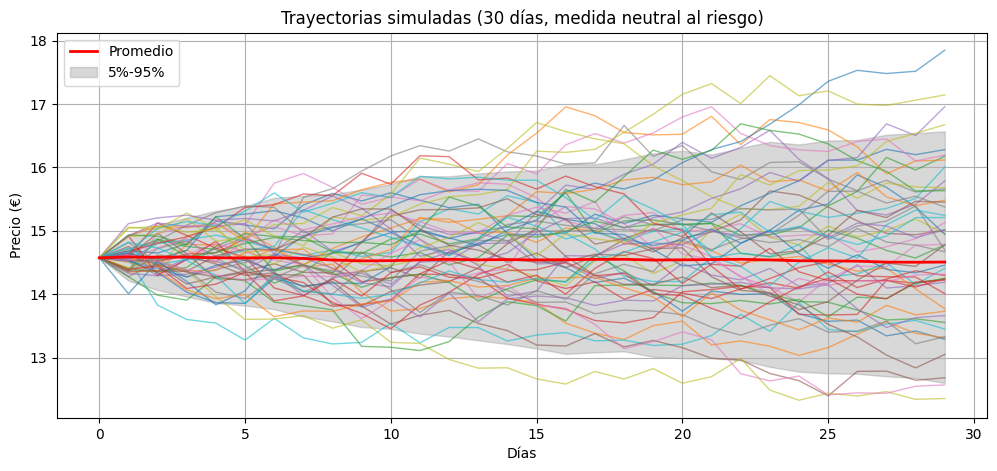

In [37]:
# Simulación Monte Carlo para opción call europea y trayectorias de precios

def mc_call_rn(S, K, T, r, q, sigma, n_paths=10000, n_steps=252):
	dt = T / n_steps
	S_paths = np.full((n_paths,), S, dtype=float)
	for _ in range(n_steps):
		z = np.random.normal(size=n_paths)
		S_paths *= np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
	payoff = np.maximum(S_paths - K, 0.0)
	price = np.exp(-r * T) * payoff.mean()
	return price

mc_price = mc_call_rn(S0, K, T, r, q, sigma_hist, n_paths=20000, n_steps=max(10, int(T_days)))

print(f"MC neutral al riesgo (call 30d): {mc_price:.4f} vs BS: {call_bs:.4f}")

# Simulación de trayectorias de precios

np.random.seed(42)

N = T_days

simulaciones = 1000

precios_futuros = np.zeros((N, simulaciones))

for i in range(simulaciones):
	precios = [S0]
	for t in range(1, N):
		drift = (r - q - 0.5 * sigma_hist ** 2) / 252
		shock = sigma_hist * np.random.normal() / np.sqrt(252)
		precios.append(precios[-1] * np.exp(drift + shock))
	precios_futuros[:, i] = precios

plt.figure(figsize=(12,5))

for i in range(50):
	plt.plot(precios_futuros[:, i], alpha=0.6, lw=1)

mean_path = precios_futuros.mean(axis=1)

p5 = np.percentile(precios_futuros, 5, axis=1)

p95 = np.percentile(precios_futuros, 95, axis=1)

plt.plot(mean_path, color='red', lw=2, label='Promedio')

plt.fill_between(range(N), p5, p95, color='gray', alpha=0.3, label='5%-95%')

plt.title('Trayectorias simuladas (30 días, medida neutral al riesgo)')

plt.xlabel('Días'); plt.ylabel('Precio (€)')

plt.legend(); plt.grid(True); plt.show()

## Greeks: interpretación y perfiles

**Teoría:**
Los "Greeks" son derivadas parciales del precio de la opción respecto a los parámetros clave. Permiten medir la sensibilidad y gestionar el riesgo de una posición:
- **Delta:** Sensibilidad al precio del subyacente
- **Gamma:** Sensibilidad de la delta
- **Vega:** Sensibilidad a la volatilidad
- **Theta:** Sensibilidad al paso del tiempo

**En la práctica:**
- Se calculan los Greeks en el punto actual (ATM).
- Se grafican los perfiles de cada Greek respecto al precio del subyacente para visualizar su comportamiento y zonas de mayor riesgo.

Greeks call ATM: delta=0.4930, gamma=0.314084, vega=1.9903, theta=-1.8153


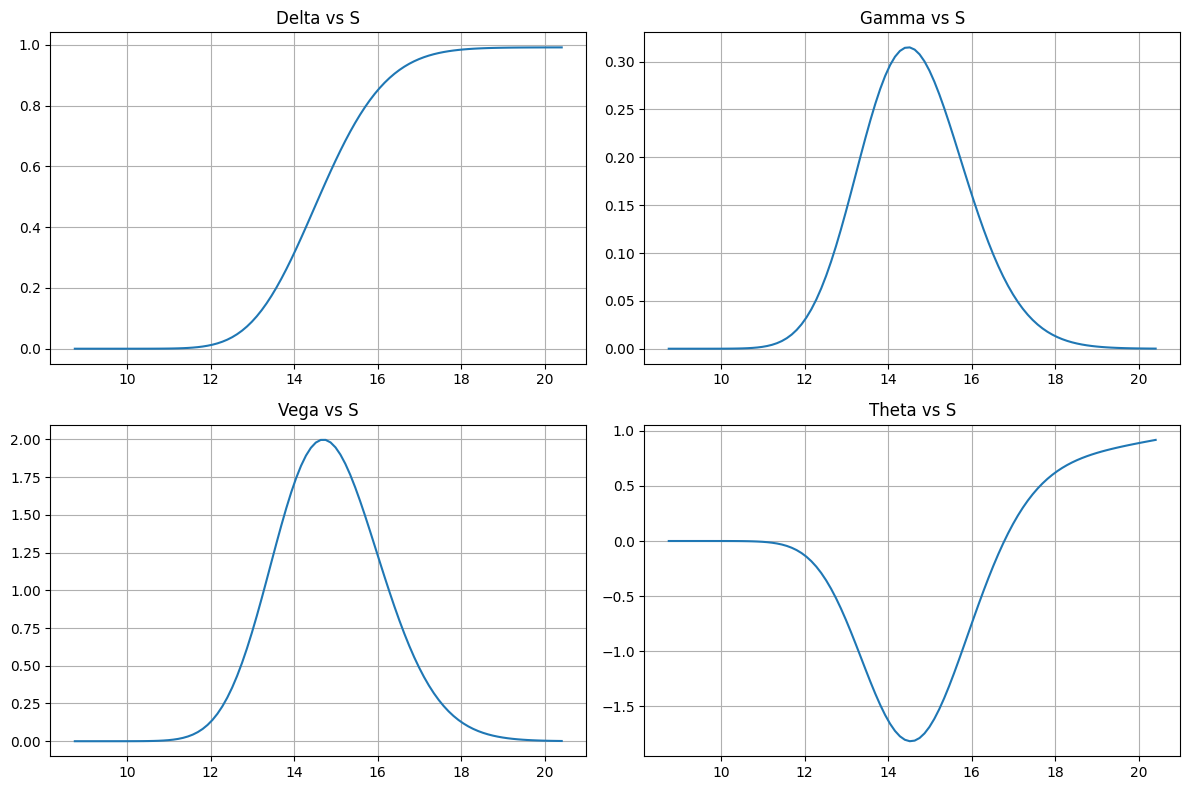

In [38]:
# Cálculo y visualización de Greeks y sus perfiles

delta_c = call_delta(S0, K, T, r, q, sigma_hist)
gamma_c = call_gamma(S0, K, T, r, q, sigma_hist)
vega_c  = call_vega(S0, K, T, r, q, sigma_hist)
theta_c = call_theta(S0, K, T, r, q, sigma_hist)
print(f"Greeks call ATM: delta={delta_c:.4f}, gamma={gamma_c:.6f}, vega={vega_c:.4f}, theta={theta_c:.4f}")

S_grid = np.linspace(0.6*S0, 1.4*S0, 100)
delta_grid = [call_delta(s, K, T, r, q, sigma_hist) for s in S_grid]
gamma_grid = [call_gamma(s, K, T, r, q, sigma_hist) for s in S_grid]
vega_grid  = [call_vega(s, K, T, r, q, sigma_hist) for s in S_grid]
theta_grid = [call_theta(s, K, T, r, q, sigma_hist) for s in S_grid]

fig, axs = plt.subplots(2,2, figsize=(12,8))
axs[0,0].plot(S_grid, delta_grid); axs[0,0].set_title("Delta vs S"); axs[0,0].grid(True)
axs[0,1].plot(S_grid, gamma_grid); axs[0,1].set_title("Gamma vs S"); axs[0,1].grid(True)
axs[1,0].plot(S_grid, vega_grid);  axs[1,0].set_title("Vega vs S");  axs[1,0].grid(True)
axs[1,1].plot(S_grid, theta_grid); axs[1,1].set_title("Theta vs S"); axs[1,1].grid(True)
plt.tight_layout(); plt.show()

# Superficie de volatilidad implícita

La volatilidad implícita es un parámetro fundamental en la valoración de opciones, ya que refleja la expectativa del mercado sobre la variabilidad futura del precio del activo subyacente. Sin embargo, en la práctica, la volatilidad implícita no es constante: varía según el precio de ejercicio (strike) y el tiempo al vencimiento de la opción. Esta dependencia se representa mediante la llamada "superficie de volatilidad implícita" (volatility surface).


La construcción de la superficie de volatilidad permite visualizar fenómenos observados empíricamente en los mercados, como el "smile" (sonrisa) o el "skew" (inclinación) de volatilidad. Estos patrones reflejan que las opciones fuera del dinero (OTM) y dentro del dinero (ITM) suelen tener volatilidades implícitas diferentes a las opciones at the money (ATM), lo que contradice la hipótesis de volatilidad constante del modelo Black-Scholes clásico.


El análisis de la superficie de volatilidad es esencial para:

- Ajustar modelos de valoración más realistas y calibrar modelos alternativos (por ejemplo, volatilidad estocástica o modelos con saltos).

- Identificar oportunidades de arbitraje y evaluar el riesgo de estrategias complejas de opciones.

- Comprender la percepción de riesgo y las expectativas del mercado en diferentes horizontes temporales y niveles de precios.


En esta sección, se estiman volatilidades implícitas para diferentes strikes y vencimientos, y se visualiza la superficie resultante en 3D. Esta herramienta es ampliamente utilizada por traders, gestores de riesgo y analistas cuantitativos para la toma de decisiones en mercados de derivados.

# Referencias bibliográficas
1. Black, F. & Scholes, M. (1973). "The Pricing of Options and Corporate Liabilities." *Journal of Political Economy*, 81(3), 637-654.
2. Merton, R. C. (1973). "Theory of Rational Option Pricing." *The Bell Journal of Economics and Management Science*, 4(1), 141-183.
3. Hull, J. C. (2022). *Options, Futures, and Other Derivatives* (11ª ed.). Pearson.
4. Wilmott, P. (2006). *Paul Wilmott On Quantitative Finance* (2ª ed.). Wiley.
5. Gatheral, J. (2006). *The Volatility Surface: A Practitioner's Guide*. Wiley Finance.
6. McDonald, R. L. (2013). *Derivatives Markets* (3ª ed.). Pearson.
7. Espen Haug, E. G. (2007). *The Complete Guide to Option Pricing Formulas* (2ª ed.). McGraw-Hill.
8. yfinance documentation: https://github.com/ranaroussi/yfinance
9. NumPy documentation: https://numpy.org/doc/
10. SciPy documentation: https://docs.scipy.org/doc/
11. Matplotlib documentation: https://matplotlib.org/stable/